# Manifold Alignment testing with toy data from Matlab

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, sparse, stats
from scipy.io import loadmat
import numpy.matlib

The Kernel Manifold Alignment method/code is copied from the following Git repository: https://github.com/dtuia/KEMA. The toy data which is used is created in MAIN_TOY_LOOPS.m and the function _gen_eig_ is copied from gen_eig.m. This way the results from the Matlab code can be compared with the Python code, to check if the Manifold Alignment is working.

In [2]:
def gen_eig(A, B, option, n_eig):
    '''
    Solves the generalized eigenvalue decomposition
    '''
    
    
    n_eig = min(n_eig, np.linalg.matrix_rank(A), np.linalg.matrix_rank(B))
    
    B = (B + B.T) / 2
    R = B.shape[0]
    rango = np.linalg.matrix_rank(B)
    
    if rango == R:
        U = np.zeros((R, n_eig))
        D = np.zerose((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        for k in range(n_eig):
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option) #'a' are the eigenvectors in the matlab code
            ab = np.matmul(a.T, B)
            a = np.divide(a, np.sqrt(np.matmul(ab, a)))
            U[:,k] = a
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            dba = np.matmul(d, ba)
            A = A - np.matmul(dba, aTb)
        
        return U, D, n_eig
    
    else:
        d, v = sparse.linalg.eigs(B, rango)
        B = np.matmul(v.T, B)
        B = np.matmul(B, v)
        
        A = np.matmul(v.T, A)
        A = np.matmul(A, v)
        
        U2 = np.zeros((n_eig, n_eig))
        D = np.zeros((n_eig, n_eig))
        inv_B = np.linalg.inv(B)
        
        for k in range(n_eig):
            
            d, a = sparse.linalg.eigs(np.matmul(inv_B, A),1, which=option)
            d = d.real
            a = a.real
            
            ab = np.matmul(a.T, B)
            aba = np.matmul(ab, a)
            a = np.divide(a, np.sqrt(aba))
            
            U2[:,k] = a.flatten()
        
            D[k,k] = d
            
            ba = np.matmul(B, a)
            aTb = np.matmul(a.T, B)
            
            dba = d * ba
            A = A - np.matmul(dba, aTb)
        
        U = np.matmul(v, U2)
        return U, D, n_eig

Run the MatLab code (MAIN_TOY_LOOPS.m) until the linear kernel building (after the Wang'11 section) with dim = 1 and r = 5, and export the MatLab workspace as a .mat file

In [5]:
kema_data = loadmat('../KEMA/data/kema_test_data_r5.mat')

In [8]:
K1 = np.matmul((np.concatenate((kema_data['X1'], kema_data['U1']), axis = 1).T),
               (np.concatenate((kema_data['X1'], kema_data['U1']), axis = 1))
              )

In [9]:
K2 = np.matmul((np.concatenate((kema_data['X2'], kema_data['U2']), axis = 1).T),
               (np.concatenate((kema_data['X2'], kema_data['U2']), axis = 1))
              )

In [10]:
K = linalg.block_diag(K1, K2)

In [11]:
KT1 = np.matmul((np.concatenate((kema_data['X1'], kema_data['U1']), axis = 1).T),
                kema_data['XT1'])

KT2 = np.matmul((np.concatenate((kema_data['X2'], kema_data['U2']), axis = 1).T),
                kema_data['XT2'])

In [12]:
KA = np.matmul(K, kema_data['A'])
KAK = np.matmul(KA, K)

KB = np.matmul(K, kema_data['B'])
KBK = np.matmul(KB, K)

In [13]:
ALPHA, LAMBDA, n_eig = gen_eig(KAK, KBK, 'LM', 4)

/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
lambda_idxs = np.diag(LAMBDA).argsort()
LAMBDA = np.sort(np.diag(LAMBDA))
LAMBDA = LAMBDA.reshape(LAMBDA.shape[0],1)

In [15]:
LAMBDA

array([[0.10596279],
       [0.47648874],
       [0.5033668 ],
       [0.50466426]])

In [16]:
ALPHA = ALPHA[:, lambda_idxs]

In [17]:
E1 = ALPHA[:kema_data['n1'].item(), :]
E2 = ALPHA[kema_data['n1'].item():, :]

In [18]:
sourceXpInv = (-1 * np.matmul(E1.T, K1)).T
sourceXp = np.matmul(E1.T, K1).T
targetXp = np.matmul(E2.T, K2).T

In [19]:
sourceXpInv = stats.zscore(sourceXpInv)
sourceXp = stats.zscore(sourceXp)
targetXp = stats.zscore(targetXp)

In [20]:
ErrRec = np.zeros((len(np.unique(kema_data['Y1'])), ALPHA.shape[1]))
ErrRecInv = np.zeros((len(np.unique(kema_data['Y1'])), ALPHA.shape[1]))

In [21]:
m1 = np.zeros((len(np.unique(kema_data['Y1'])), ALPHA.shape[1]))
m1inv = np.zeros((len(np.unique(kema_data['Y1'])), ALPHA.shape[1]))
m2 = np.zeros((len(np.unique(kema_data['Y1'])), ALPHA.shape[1]))

In [22]:
cls = np.unique(kema_data['Y1'])

In [23]:
for j in range(ALPHA.shape[1]):
    for i in range(len(np.unique(kema_data['Y1']))):
        m1inv[i,j] = np.mean(sourceXpInv[(np.concatenate((kema_data['Y1'], 
                                                          kema_data['Y1U']), 
                                                         axis=0) == cls[i]).flatten(), j])
        #print('m1inv: ', m1inv)
        m1[i,j] = np.mean(sourceXp[(np.concatenate((kema_data['Y1'], 
                                                          kema_data['Y1U']), 
                                                         axis=0) == cls[i]).flatten(), j])
        #print('m1: ', m1)
        m2[i,j] = np.mean(targetXp[(np.concatenate((kema_data['Y2'], 
                                                    kema_data['Y2U']), axis=0) == cls[i]).flatten(), j])
        #print('m2: ', m2)
        ErrRec[i,j] = np.square(np.power((np.mean(sourceXp[(np.concatenate((kema_data['Y1'], 
                                                                           kema_data['Y1U']), 
                                                                          axis=0) == cls[i]).flatten(), j]) -
                                          np.mean(targetXp[(np.concatenate((kema_data['Y2'], 
                                                                           kema_data['Y2U']), 
                                                                          axis=0) == cls[i]).flatten(), j])),
                                         2))
        
        ErrRecInv[i,j] = np.square(np.power((np.mean(sourceXpInv[(np.concatenate((kema_data['Y1'], 
                                                                                 kema_data['Y1U']), 
                                                                                axis=0) == cls[i]).flatten(), j]) -
                                             np.mean(targetXp[(np.concatenate((kema_data['Y2'], 
                                                                              kema_data['Y2U']), 
                                                                             axis=0) == cls[i]).flatten(), j])),2))
        


/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':
/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/mnt/guanabana/raid/home/arend036/pim_msc/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


In [24]:
Sc = ErrRec.max(axis=0) > ErrRecInv.max(axis=0)

In [25]:
ALPHA[:530, Sc] = ALPHA[:530, Sc] * -1

Project the data

In [26]:
nVectLin = min(kema_data['NF'], np.linalg.matrix_rank(KBK))
nVectLin = min(nVectLin, np.linalg.matrix_rank(KAK))

In [27]:
for Nf in range(nVectLin):
    E1 = ALPHA[:kema_data['n1'].item(), :Nf+1]
    E2 = ALPHA[kema_data['n1'].item():, :Nf+1]
    Phi1toF = np.matmul(E1.T, K1)
    Phi2toF = np.matmul(E2.T, K2)
    
    Phi1TtoF = np.matmul(E1.T, KT1)
    Phi2TtoF = np.matmul(E2.T, KT2)
    
    m1 = np.mean(Phi1toF.T, axis = 0)
    m2 = np.mean(Phi2toF.T, axis = 0)
    s1 = np.std(Phi1toF.T, axis = 0)
    s2 = np.std(Phi2toF.T, axis =0)
    
    Phi1toF = stats.zscore(Phi1toF.T).T
    Phi2toF = stats.zscore(Phi2toF.T).T
    
    Phi1TtoF = np.divide((Phi1TtoF.T - np.matlib.repmat(m1,2*kema_data['T'].item(),1)), 
                         np.matlib.repmat(s1,2*kema_data['T'].item(),1)).T
    
    Phi2TtoF = np.divide((Phi2TtoF.T - np.matlib.repmat(m2,2*kema_data['T'].item(),1)),
                         np.matlib.repmat(s2,2*kema_data['T'].item(),1)).T

In [28]:
Phi1TtoF_Lin = Phi1TtoF
Phi2TtoF_Lin = Phi2TtoF

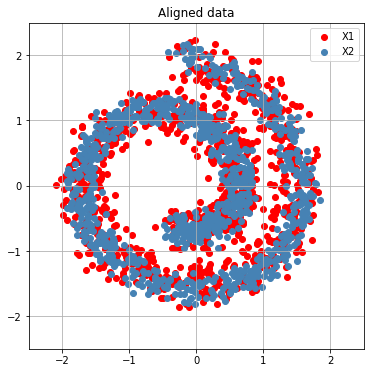

In [34]:
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter(Phi1TtoF_Lin[0,:], Phi1TtoF_Lin[1,:], label = 'X1', color = 'red')
plt.scatter(Phi2TtoF_Lin[0,:], Phi2TtoF_Lin[1,:], label = 'X2', color = 'steelblue')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5, 2.5])

plt.legend()
plt.title('Aligned data')
plt.show()

Plot original data

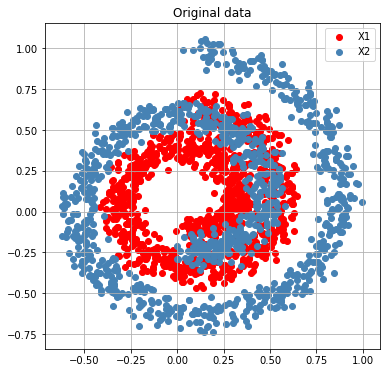

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(kema_data['XT1'][0,:], kema_data['XT1'][1,:], label = 'X1', color='red')
plt.scatter(kema_data['XT2'][0,:], kema_data['XT2'][1,:], label = 'X2', color= 'steelblue')
plt.legend()
plt.grid()
plt.title('Original data')
plt.show()